In [2]:

from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

import pandas as pd

In [183]:

nb_of_clusters = 5
dataset, _ = datasets.make_blobs(n_samples=10000, centers=nb_of_clusters, n_features=2)  # n_features : nombre de dimensions


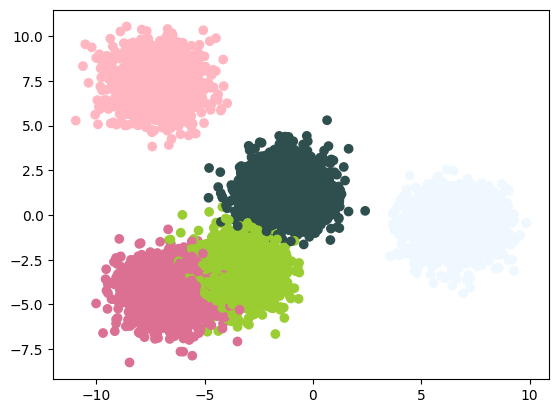

In [184]:
def visualize_clustersV1(dataset, centers=None, title=None):

    colors = list(mcolors.CSS4_COLORS.keys())
    plt.scatter(dataset[:, 0], dataset[:, 1], c=_, cmap=mcolors.ListedColormap(colors))

    if centers is not None:
        plt.scatter(centers[:, 0], centers[:, 1], c='red')
    plt.show()


visualize_clustersV1(dataset)

In [121]:
def visualize_clusters(dataset, centers=None, title=None):
    colors = list(mcolors.CSS4_COLORS.keys())
    if dataset.shape[1] == 2:
        plt.scatter(dataset[:, 0], dataset[:, 1], c=_, cmap=mcolors.ListedColormap(colors))
    elif dataset.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(dataset[:, 0], dataset[:, 1], dataset[:, 2], c=_, cmap=mcolors.ListedColormap(colors))
    else:
        raise ValueError("Visualization not implemented for more than 3 dimensions")

    if centers is not None:
        if centers.shape[1] == 2:
            plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='x', s=100)  # Use 'x' marker with larger size
        elif centers.shape[1] == 3:
            ax.scatter(centers[:, 0], centers[:, 1], centers[:, 2], c='red', marker='x', s=100)
        else:
            raise ValueError("Visualization not implemented for more than 3 dimensions")

    plt.show()

In [88]:

def sse_distance(a, b):
    return np.sum((a-b)**2)

def find_closest_center(centers, data):
    distances = []
    for center in centers:
        distances.append(sse_distance(center, data))
    return np.argmin(distances)

def compute_clusters(centers, data):
    clusters = []
    for point in data:
        clusters.append(find_closest_center(centers, point))
    return clusters

def sse_error(centers, data):
    clusters = compute_clusters(centers, data)
    error = 0
    for i in range(len(clusters)):
        error += sse_distance(data[i], centers[clusters[i]])
    return error


In [97]:
##############################
#
# KMEANS ++
#
##############################
def initialize_centers2(data, k):
    centers = []
    # Sélectionner aléatoirement le premier centre parmi les points de données
    centers.append(data[np.random.randint(0, len(data))])

    for _ in range(1, k):
        distances = []
        for point in data:
            # Pour chaque point, calculer la distance au centre le plus proche déjà choisi
            min_distance = min(sse_distance(point, c) for c in centers)
            distances.append(min_distance)

        # Probabilité proportionnelle à la distance au centre le plus proche déjà choisi
        probabilities = np.array(distances) / sum(distances)
        
        # Choisir le nouveau centre avec une probabilité proportionnelle à la distance au centre déjà choisi
        new_center_index = np.random.choice(len(data), p=probabilities)
        centers.append(data[new_center_index])

    return np.array(centers)



In [122]:
def initialize_centers(data, k):
    centers = []
    for i in range(k):
        centers.append(data[np.random.randint(0, len(data))])
    return centers

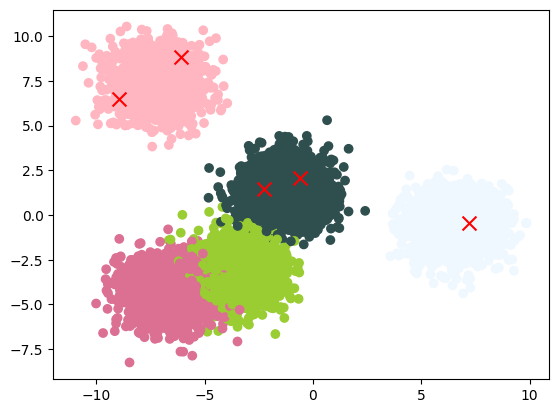

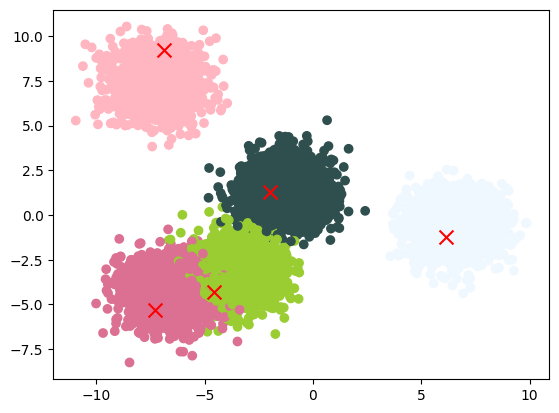

In [215]:

visualize_clusters(dataset, np.array(initialize_centers(dataset, nb_of_clusters))) # Initialisation aléatoire
visualize_clusters  (dataset, np.array(initialize_centers2(dataset, nb_of_clusters))) # KMEANS ++

Iteration 1, SSE = 275159.8787795816


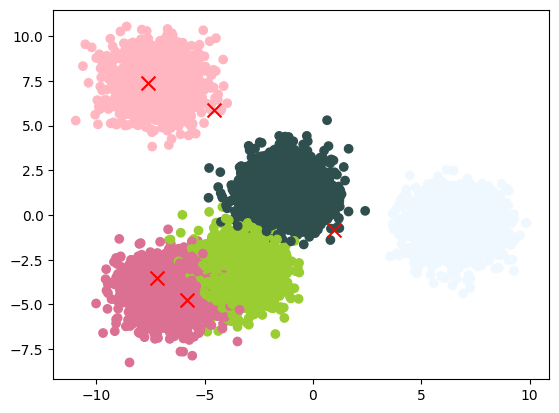

Iteration 2, SSE = 113405.71344649301


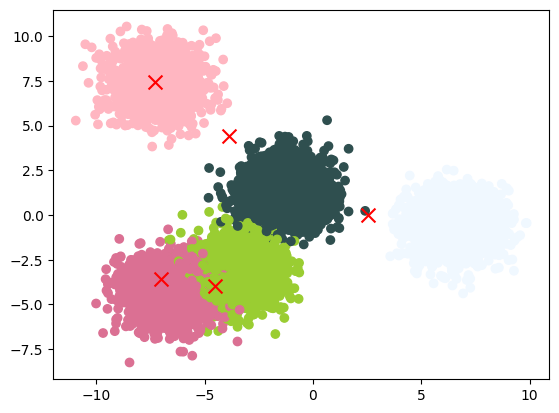

Iteration 3, SSE = 76664.05874139776


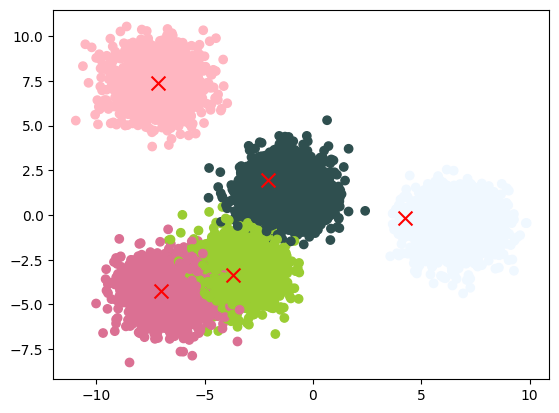

Iteration 4, SSE = 32812.84928932352


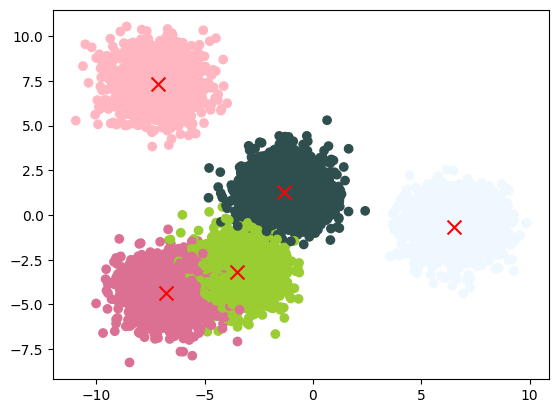

Iteration 5, SSE = 19665.801212713155


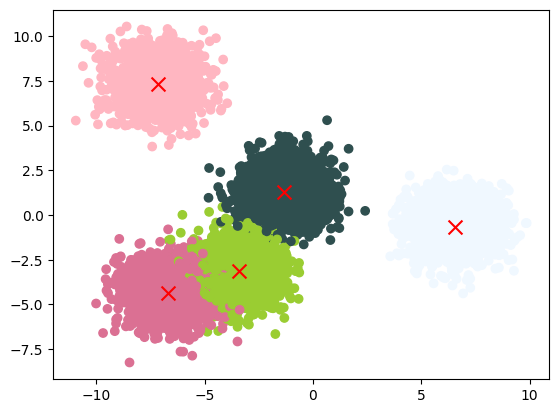

Iteration 6, SSE = 19627.071523208462


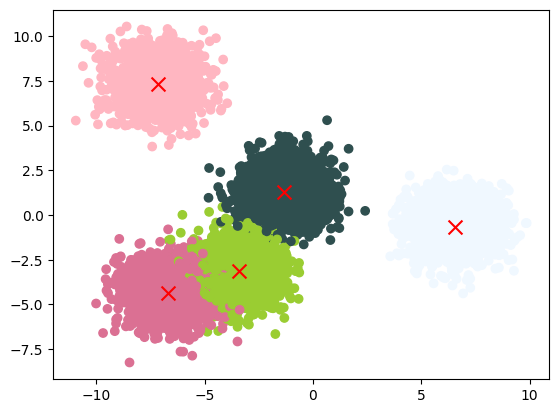

Iteration 7, SSE = 19622.549942277798


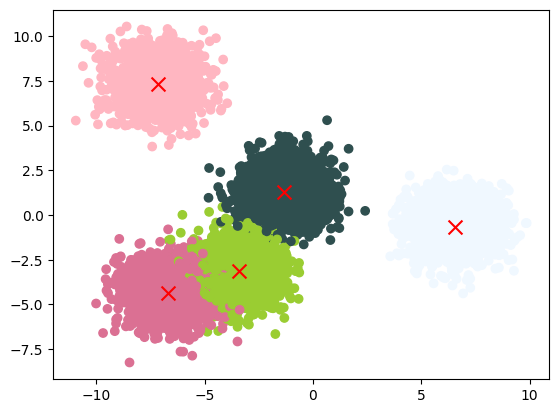

Convergence atteinte après 7 itérations.


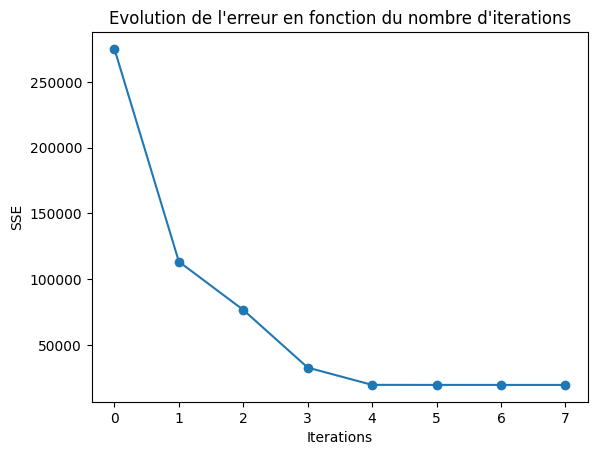

In [218]:
def kmeans(data, k, num_it ,centers=centers):
    centers_history = []
    sse_history = []
    tolerance=1

    # Initialisation des centres
    centers = initialize_centers(data, k)
    #centers = initialize_centers2(data, k) # pour kmeans ++

    

    for i in range(num_it):
        centers_history.append(np.array(centers))
        
        # Attribution des clusters
        clusters = compute_clusters(centers, data)
        
        # Calcul du SSE
        sse = sse_error(centers, data)
        sse_history.append(sse)
        
        # Mise à jour des centres
        new_centers = []
        for cluster_id in range(k):
            cluster_points = np.array([data[j] for j in range(len(data)) if clusters[j] == cluster_id])
            new_centers.append(np.mean(cluster_points, axis=0))
        # Si les centres n'ont pas changé, on a atteint la convergence
        if i > 0 and abs(sse_history[i-1] - sse) < tolerance:
            print(f"Convergence atteinte après {i} itérations.")
            break
        centers = new_centers
        print(f"Iteration {i+1}, SSE = {sse}")
        visualize_clustersDim(data, np.array(centers))


    # Dernière mise à jour des centres et SSE
    clusters = compute_clusters(centers, data)
    sse = sse_error(centers, data)
    centers_history.append(np.array(centers))
    sse_history.append(sse)
    

    # Affichage de l'évolution de l'erreur en fonction du nombre d'itérations
    plt.plot(range(i+1), sse_history[:-1], marker='o')
    plt.xlabel('Iterations')
    plt.ylabel('SSE')
    plt.title('Evolution de l\'erreur en fonction du nombre d\'iterations')
    plt.show()

    # Retourne l'historique des centres et l'historique de SSE
    history = {'centers_history': centers_history, 'sse_history': sse_history}
    return history
h= kmeans(dataset,nb_of_clusters, 100)

Iteration 1, SSE=612.162563225791
Iteration 2, SSE=279.7510022806424
Iteration 3, SSE=254.94044407052175
Convergence atteinte à l'itération 3


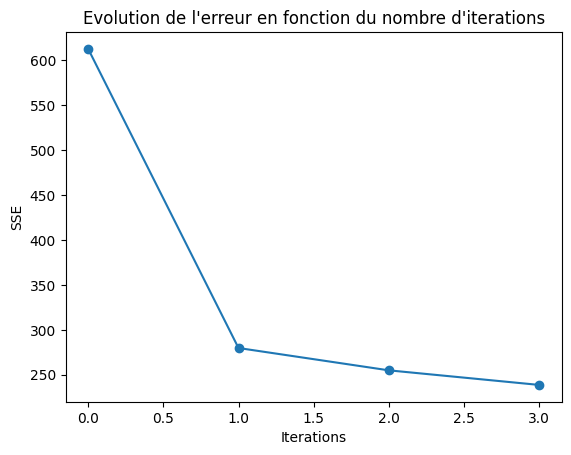

In [219]:
def kmeansb(data, k, num_it, batch_size=32):
    tolerance=1
    centers_history = []
    sse_history = []

    # Initialisation des centres
    centers = initialize_centers(data, k)

    for i in range(num_it):
        centers_history.append(np.array(centers))
        
        # Randomly select a batch of data points
        batch_indices = np.random.choice(len(data), size=batch_size, replace=False)
        batch_data = data[batch_indices]
        
        # Attribution des clusters
        clusters = compute_clusters(centers, batch_data)
        
        # Calcul du SSE
        sse = sse_error(centers, batch_data)
        sse_history.append(sse)
        
        # Mise à jour des centres
        new_centers = []
        for cluster_id in range(k):
            cluster_points = np.array([batch_data[j] for j in range(len(batch_data)) if clusters[j] == cluster_id])
            if len(cluster_points) > 0:
                new_centers.append(np.mean(cluster_points, axis=0))
            else:
                new_centers.append(centers[cluster_id])  # If a cluster is empty, keep the center unchanged
        
        #  si la distance entre les nouveaux centres et les anciens centres est inférieure à la tolérance, on a atteint la convergence
        if np.linalg.norm(np.array(new_centers) - np.array(centers)) < tolerance:
            print(f"Convergence atteinte à l'itération {i}")
            break

        centers = new_centers
        print(f"Iteration {i+1}, SSE={sse}")
        
        # visualize_clusters(data, np.array(centers))  # You can implement this function for visualization if needed

    # Dernière mise à jour des centres et SSE
    clusters = compute_clusters(centers, data)
    sse = sse_error(centers, data)
    centers_history.append(np.array(centers))
    sse_history.append(sse)

    # Affichage de l'évolution de l'erreur en fonction du nombre d'itérations
    plt.plot(range(i+1), sse_history[:-1], marker='o')

    plt.xlabel('Iterations')
    plt.ylabel('SSE')
    plt.title('Evolution de l\'erreur en fonction du nombre d\'iterations')
    plt.show()

    # Retourne l'historique des centres et l'historique de SSE
    history = {'centers_history': centers_history, 'sse_history': sse_history}
    return history


h = kmeansb(dataset, nb_of_clusters, 100, batch_size=60)

Le choix du batch_size (taille du mini-batch) dans l'algorithme de mini-batch k-means peut avoir plusieurs implications sur la convergence, la performance et la qualité des résultats. Voici quelques points à considérer :

    Vitesse de convergence : Un batch_size plus grand peut accélérer la convergence car il utilise un échantillon plus important pour mettre à jour les centres. Cependant, un batch_size trop grand peut également entraîner des mises à jour de centres moins fréquentes, ce qui peut ralentir la convergence. Il est important de trouver un équilibre.

    Consommation de mémoire : Un batch_size plus grand nécessite plus de mémoire car il stocke un ensemble plus important de données en mémoire à chaque itération. Cela peut être une considération importante, en particulier pour de grands ensembles de données.

    Stabilité des résultats : Des mini-batchs plus petits peuvent conduire à des mises à jour de centres plus fréquentes, ce qui peut rendre l'algorithme plus stable. Cependant, cela peut également introduire une certaine variabilité dans les mises à jour, ce qui peut influencer la qualité des résultats.

    Sensibilité aux points extrêmes : Des mini-batchs plus petits peuvent être plus sensibles aux points extrêmes (outliers) présents dans le mini-batch, ce qui peut affecter la qualité des mises à jour de centres.

    Adaptabilité à la mémoire : Si la mémoire est limitée, un petit batch_size peut être nécessaire pour que l'algorithme s'exécute sur la configuration matérielle disponible.

En général, le choix du batch_size dépend du compromis entre la vitesse de convergence, la stabilité des résultats, la consommation de mémoire et d'autres contraintes matérielles. Il peut être utile d'expérimenter avec différentes valeurs de batch_size pour trouver celle qui fonctionne le mieux pour votre ensemble de données spécifique et vos objectifs.